In [1]:
# 필요한 기본 패키지 준비

# 데이터 처리 필요 패키지
import numpy as np
import pandas as pd
import datetime as dt
import math

# 시각화 필요 패키지
%matplotlib inline
from plotnine import *
import folium
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import seaborn as sns


# Machine Learning 분석 환경 준비

# 전처리, 스케일링
from sklearn.preprocessing import StandardScaler

# 선형회귀분석
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# OLS회귀분석
import statsmodels.api as sm

# GAM 일반화가법모형
# LinearGAM, LogisticGAM, PoissonGAM, GammaGAM, InvGuss
from pygam import LinearGAM, LogisticGAM, PoissonGAM, GammaGAM

# Boosting

#데이터셋 분리
from sklearn.model_selection import train_test_split



# 한글 처리
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# jupyter notebook에서 warning 무시하기
import warnings
warnings.filterwarnings("ignore")

In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1))
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

In [4]:
# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

# 컬럼 이름을 변경하여 Series로 돌려주는 함수
sns_all.columns = changeColNames(sns_all,'.','_')
# ols formula입력시 오류 발생 방지를위해 컬럼명 문자열 내, 마침표(.)가 전부 underscore(_)로 변경
# sns_all.columns

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']
lv_grouped = lv_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()
# lv_grouped.tail(2)

랄라블라
1. 선케어
2. 바디로션
3. 제모제

GS
1. 마스크
2. 맥주
3. 아이스크림

# 선케어

## 일단위 자료
#### 함수를 만들기전, 함수에 들어갈 코딩을 위한 사전 작업

In [5]:
# 서울특별시 단위로 df조정(구단위 데이터 합치기)
day_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()
# day_lv_grouped.tail(3)

# '선케어'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'day_gs_grouped_w_item'생성
item = '선케어'
day_lv_grouped_w_item = pd.merge(day_lv_grouped.loc[day_lv_grouped.category==item],w_seoul,on='date',how='left')
day_lv_grouped_w_sns_item = pd.merge(day_lv_grouped_w_item, sns_all,on='date',how='left')

# ind_vars = ['temp','humid','wind','sun_time']
# ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time']
# ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time'
#                 ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']

ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']

linReg(day_lv_grouped_w_sns_item,item,ind_vars)
ridgeReg(day_lv_grouped_w_sns_item,item,ind_vars)
lassoReg(day_lv_grouped_w_sns_item,item,ind_vars)

Xy = day_lv_grouped_w_sns_item.loc[day_lv_grouped_w_sns_item['category']==item,ind_vars+['qty']]
model = sm.OLS.from_formula("qty ~ temp + sun_time + cloud + health_total + date_total", data=Xy)
# model = sm.OLS.from_formula("qty ~ temp + humid + sun_time + rain", data=Xy)
# model = sm.OLS.from_formula("qty ~ temp", data=Xy)

print(model.fit().summary())

LinearRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.43
검증세트점수 : 0.46
RidgeRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.42
검증세트점수 : 0.46
LassoRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.43
검증세트점수 : 0.46
사용한 특성수 : 12
                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     160.4
Date:                Thu, 11 Jul 2019   Prob (F-statistic):          8.30e-128
Time:                        16:23:33   Log-Likelihood:                -10443.
No. Observations:                1096   AIC:                         2.090e+04
Df Residuals:                    1090   BIC:                         2.093e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
    

## 주단위 자료 생성

### 선케어만
#### 자료생성 파트

In [6]:
cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# '선케어'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
item = '선케어'
week_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()
# week_lv_grouped.tail(2)
week_lv_grouped_gu =week_lv_grouped.loc[week_lv_grouped.category==item]
# week_lv_grouped_gu.tail(3)

# '마스크'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
week_lv_grouped_item = week_lv_grouped.loc[week_lv_grouped.category==item].reset_index()
# 이제 'week_lv_grouped_item'에 한 날짜에 한 item(선케어)만 들어가있는 df가 됨.

week_lv_grouped_w_item = pd.merge(week_lv_grouped,w,on='date',how='left')
week_lv_grouped_w_item_sns = pd.merge(week_lv_grouped_w_item,sns_all,on='date',how='left')
# week_lv_grouped_w_item_sns.tail(2)


week_w = addDayWeek(w_seoul)
week_w = week_w.groupby('week').mean().reset_index()
week_w.drop(columns=['loc','day','year','month','weekday','nth_week'], inplace=True)
# week_w.tail(2)

# sns자료는 2019년 4월달 자료 까지 있다.
week_sns = addDayWeek(sns_all.loc[sns_all.date.between('2016-01-01','2018-12-31', inclusive=True)])
# week_sns = week_sns.groupby('week').sum().reset_index()
week_sns = week_sns.groupby('week').mean().reset_index()
# week_sns.tail(2)

check = addDayWeek(week_lv_grouped_item)
check.drop(columns='index',inplace=True)
# check = check[['week','category','qty']].groupby(by=['week','category']).sum().reset_index()
check = check[['week','category','qty']].groupby(by=['week','category']).mean().reset_index()
# check.tail()
check_merged = mergeForAnalysis(check, week_w, week_sns, item, on_what='week')
# check_merged.columns

#### 예측모델 파트

In [7]:
ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']

linReg(check_merged,item,ind_vars)
ridgeReg(check_merged,item,ind_vars)
lassoReg(check_merged,item,ind_vars)
print('')
# ols모델
Xy = check_merged.loc[check_merged['category']==item, ind_vars+['qty']]

model = sm.OLS.from_formula(
    "qty ~ I(temp**2)"
    , data=Xy)
# model = sm.OLS.from_formula("qty ~ temp + pm_total + health_total ", data=Xy)

print(model.fit().summary())

LinearRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.65
검증세트점수 : 0.58
RidgeRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.64
검증세트점수 : 0.54
LassoRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.65
검증세트점수 : 0.58
사용한 특성수 : 12

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     91.43
Date:                Thu, 11 Jul 2019   Prob (F-statistic):           2.58e-17
Time:                        16:23:39   Log-Likelihood:                -1475.2
No. Observations:                 157   AIC:                             2954.
Df Residuals:                     155   BIC:                             2960.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
   

# uv데이터를 사용해서 예측진행
## uv 데이터 사용전 데이터 처리

In [8]:
cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# '선케어'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
item = '선케어'
week_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()
# week_lv_grouped.tail(2)
week_lv_grouped_gu =week_lv_grouped.loc[week_lv_grouped.category==item]
# week_lv_grouped_gu.tail(3)

# '마스크'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
week_lv_grouped_item = week_lv_grouped.loc[week_lv_grouped.category==item].reset_index()
# 이제 'week_lv_grouped_item'에 한 날짜에 한 item(선케어)만 들어가있는 df가 됨.

week_lv_grouped_w_item = pd.merge(week_lv_grouped,w,on='date',how='left')
week_lv_grouped_w_item_sns = pd.merge(week_lv_grouped_w_item,sns_all,on='date',how='left')
# week_lv_grouped_w_item_sns.tail(2)


week_w = addDayWeek(w_seoul)
week_w = week_w.groupby('week').mean().reset_index()
week_w.drop(columns=['loc','day','year','month','weekday','nth_week'], inplace=True)
# week_w.tail(2)

# sns자료는 2019년 4월달 자료 까지 있다.
week_sns = addDayWeek(sns_all.loc[sns_all.date.between('2016-01-01','2018-12-31', inclusive=True)])
# week_sns = week_sns.groupby('week').sum().reset_index()
week_sns = week_sns.groupby('week').mean().reset_index()
# week_sns.tail(2)

check = addDayWeek(week_lv_grouped_item)
check.drop(columns='index',inplace=True)
# check = check[['week','category','qty']].groupby(by=['week','category']).sum().reset_index()
check = check[['week','category','qty']].groupby(by=['week','category']).mean().reset_index()
# check.tail()
check_merged = mergeForAnalysis(check, week_w, week_sns, item, on_what='week')
# check_merged.columns

In [14]:
# uv데이터는 결측치가 많다.
print('UV 데이터 포함(결측치가 있는 주는 제거)\n')
check_merged = check_merged.loc[check_merged.uv.notnull()]
ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time', 'uv'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']

linReg(check_merged,item,ind_vars)
ridgeReg(check_merged,item,ind_vars)
lassoReg(check_merged,item,ind_vars)
print('')
# ols모델
Xy = check_merged.loc[check_merged['category']==item, ind_vars+['qty']]

model = sm.OLS.from_formula(
    "qty ~ temp + uv + hobby_total"
    , data=Xy)
# model = sm.OLS.from_formula("qty ~ temp + pm_total + health_total ", data=Xy)

print(model.fit().summary())

UV 데이터 포함(결측치가 있는 주는 제거)

LinearRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.62
검증세트점수 : 0.72
RidgeRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.60
검증세트점수 : 0.77
LassoRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.62
검증세트점수 : 0.72
사용한 특성수 : 13

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     48.84
Date:                Thu, 11 Jul 2019   Prob (F-statistic):           1.38e-19
Time:                        16:24:54   Log-Likelihood:                -964.50
No. Observations:                 105   AIC:                             1937.
Df Residuals:                     101   BIC:                             1948.
Df Model:                           3                                         
Covariance Type:            nonrobust                   

<function matplotlib.pyplot.show(*args, **kw)>

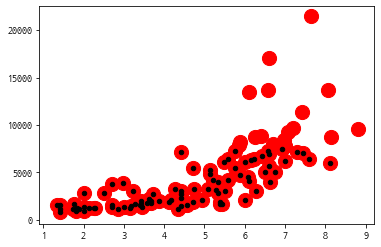

In [15]:
plt.scatter(Xy['uv'],Xy['qty'], c='r',s=200)

Xy_no_outlier = Xy.copy()
Xy_no_outlier['outlier'] = mad_based_outlier(Xy_no_outlier['qty'],thresh=1.5)
Xy_no_outlier = Xy_no_outlier.loc[Xy_no_outlier.outlier==False]
#Xy_no_outlier = Xy.loc[Xy.qty<12_000]

plt.scatter(Xy_no_outlier['uv'],Xy_no_outlier['qty'], c='k',s=20)
plt.show

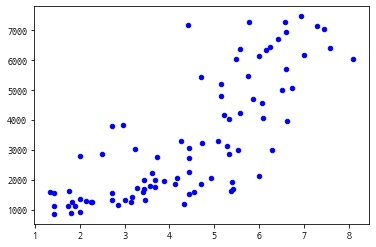

In [16]:
plt.scatter(Xy_no_outlier['uv'],Xy_no_outlier['qty'], c='b',s=20)

In [17]:
model = sm.OLS.from_formula(
    "qty ~ I(uv**2)"
    , data=Xy_no_outlier)


# model = sm.OLS.from_formula("qty ~ temp + uv + pm_total + health_total ", data=Xy)
ols_model = model.fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     151.1
Date:                Thu, 11 Jul 2019   Prob (F-statistic):           1.50e-20
Time:                        16:25:18   Log-Likelihood:                -741.39
No. Observations:                  87   AIC:                             1487.
Df Residuals:                      85   BIC:                             1492.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    925.9228    232.724      3.979      0.0

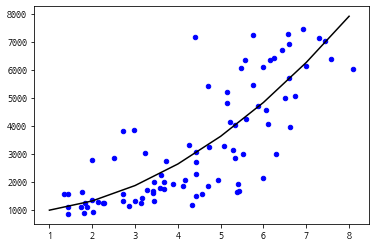

In [18]:
c1 = 109.8961
intercept = 889.3919
plt.scatter(Xy_no_outlier['uv'],Xy_no_outlier['qty'], c='b',s=20)
uv_list = pd.Series(list(range(int(Xy_no_outlier.uv.min()),int(Xy_no_outlier.uv.max())+1)))
plt.plot(uv_list, intercept + c1*(uv_list ** 2), c='k')
plt.show()

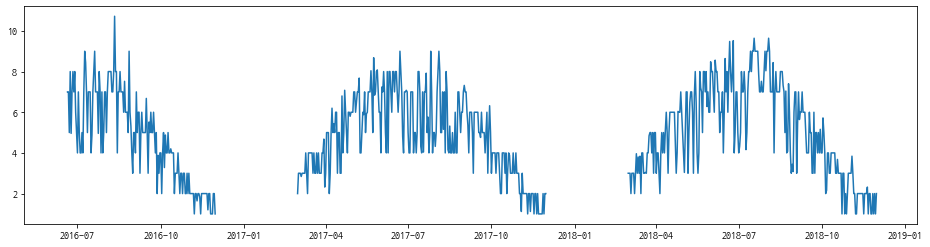

In [19]:
# 일단위 3년간의 평균 uv지수 변화
w_day_temp = w[['date','uv']]
w_day_temp['day'] = pd.Series(range(1,w_day_temp.shape[0]+1))
w_day_temp['week'] = w_day_temp['day'].apply(lambda x : math.ceil(x/7))
plt.figure(figsize=(16,4))
plt.plot(w_day_temp['date'],w_day_temp['uv'])

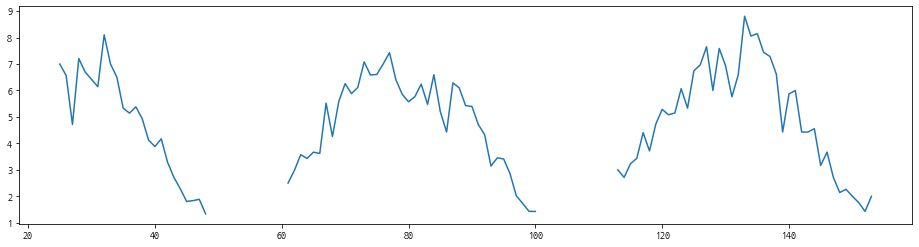

In [20]:
# 주단위 3년간의 평균 uv지수 변화
w_week_temp = week_w[['week','uv']]
plt.figure(figsize=(16,4))
plt.plot(w_week_temp['week'],w_week_temp['uv'])